# Data Upload

In [1]:
# Main Packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import calendar
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
import plotly.express as px

In [2]:
import sqlite3
conn = sqlite3.connect(":memory:")

In [3]:
# Customers, Sellers 
customers= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_customers_dataset.csv')
sellers= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_sellers_dataset.csv')

# Product 
products= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_products_dataset.csv')
products_name = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_category_name_translation.csv')

# Order 
orders= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_orders_dataset.csv')
orders_item= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_items_dataset.csv')
orders_payment= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_payments_dataset.csv')
orders_review= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_reviews_dataset.csv')

# Data Preprocessing

## Data Integration

In [42]:
full_data = pd.merge(orders,orders_item,left_on='order_id',right_on='order_id')
full_data = full_data.merge(orders_payment,on ='order_id')
full_data = full_data.merge(orders_review,on ='order_id')
full_data = full_data.merge(customers,on ='customer_id')
full_data = full_data.merge(sellers,on ='seller_id')
full_data = full_data.merge(products,on ='product_id')
full_data = full_data.merge(products_name,on ='product_category_name')

## Data Reduction

In [43]:
full_data.drop(['product_name_lenght',	'product_description_lenght'	,'product_photos_qty'	,'product_weight_g'	,
                'product_length_cm',	'product_height_cm'	,'product_width_cm','product_category_name','review_comment_title',
                'review_comment_message','review_creation_date','review_answer_timestamp','order_delivered_carrier_date'],axis=1,inplace=True)

## Data Cleaning - Missing Data

In [ ]:
for feature in full_data.columns:
  if full_data[feature].isnull().sum() >=1:
    print(feature,  '---> total nulls are',(full_data[feature].isnull().sum()))

order_approved_at ---> total nulls are 14
order_delivered_customer_date ---> total nulls are 2400


In [44]:
#Fill the nulls --> order_approved_at
full_data["order_approved_at"].fillna(full_data["order_purchase_timestamp"], inplace=True)
#Fill the nulls --> order_delivered_customer_date
full_data["order_delivered_customer_date"].fillna(full_data["order_estimated_delivery_date"], inplace=True)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115609 non-null  object 
 5   order_delivered_customer_date  115609 non-null  object 
 6   order_estimated_delivery_date  115609 non-null  object 
 7   order_item_id                  115609 non-null  int64  
 8   product_id                     115609 non-null  object 
 9   seller_id                      115609 non-null  object 
 10  shipping_limit_date            115609 non-null  object 
 11  price                          115609 non-null  float64
 12  freight_value                 

## Data Transformation and Feature Extraction

In [45]:
#As the type of the purchase date is object, the type datetime64[ns] is converted first.
#And time, day, month, month-year and year information is received
full_data['order_purchase_timestamp'] = full_data['order_purchase_timestamp'].apply(pd.to_datetime)
full_data['purchase_time'] = full_data['order_purchase_timestamp'].dt.hour
full_data['purchase_MonthY'] = full_data['order_purchase_timestamp'].dt.to_period('M')
full_data['purchase_year'] = full_data['order_purchase_timestamp'].dt.year
full_data['purchase_month'] =  pd.Series(pd.Categorical(full_data['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)))
full_data['purchase_day'] = pd.Series(pd.Categorical(full_data['order_purchase_timestamp'].dt.day_name(), categories=list(calendar.day_name)))

In [46]:
# Date information formatted as %Y-%m-%d

Dates = ['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
      'order_estimated_delivery_date','shipping_limit_date'
       ,'order_delivered_customer_date']
for columns in Dates:
  full_data[columns] = pd.to_datetime(full_data[columns], format='%Y-%m-%d').dt.date

In [47]:
#Estimated Delivery Date - Actual Delivery Date = Delta (Difference) on Delivery Date
full_data['shipping_time_delta'] = full_data['order_estimated_delivery_date'] - full_data['order_delivered_customer_date']

#Actual Delivery Date - Purchase Date = Actual Delivery Time
full_data['shipping_duration'] = full_data['order_delivered_customer_date'] - full_data['order_purchase_timestamp']

#Estimated Delivery Date - Purchased Date = Estimated Delivery Time
full_data['estimated_duration'] = full_data['order_estimated_delivery_date'] - full_data['order_purchase_timestamp']

In [48]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       115609 non-null  object         
 1   customer_id                    115609 non-null  object         
 2   order_status                   115609 non-null  object         
 3   order_purchase_timestamp       115609 non-null  object         
 4   order_approved_at              115609 non-null  object         
 5   order_delivered_customer_date  115609 non-null  object         
 6   order_estimated_delivery_date  115609 non-null  object         
 7   order_item_id                  115609 non-null  int64          
 8   product_id                     115609 non-null  object         
 9   seller_id                      115609 non-null  object         
 10  shipping_limit_date            115609 non-null  object  

## Data Overview


In [7]:
totalOrders = full_data.order_id.nunique()

print('Unique customer cities:',full_data.customer_city.nunique())
print('Unique customer states:',full_data.customer_state.nunique())
print('Unique seller cities:',full_data.seller_city.nunique())
print('Unique seller states:',full_data.seller_state.nunique())
print('Average price:',full_data.price.sum() / totalOrders)
print('Average qnt of products by order:',full_data.order_item_id.sum() / totalOrders)
print('Average freight price:',full_data.freight_value.sum() / totalOrders)
print('Total revenue for the period was:',full_data.price.sum())
print('Number of unique customers:',full_data.customer_unique_id.nunique())
print('Total order quantity:', totalOrders)
print('Average number of product by order:',full_data.freight_value.sum() / totalOrders)

Unique customer cities: 4093
Unique customer states: 27
Unique seller cities: 604
Unique seller states: 23
Average price: 144.48112426955115
Average qnt of products by order: 1.430840482407062
Average freight price: 24.02457406025944
Total revenue for the period was: 13944740.19
Number of unique customers: 93396
Total order quantity: 96516
Average number of product by order: 24.02457406025944


In [49]:
full_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,purchase_time,purchase_MonthY,purchase_year,purchase_month,purchase_day,shipping_time_delta,shipping_duration,estimated_duration
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-10,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,10,2017-10,2017,October,Monday,8 days,8 days,16 days
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-10,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,10,2017-10,2017,October,Monday,8 days,8 days,16 days
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-10,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares,10,2017-10,2017,October,Monday,8 days,8 days,16 days
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-18,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21,29.99,7.78,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares,18,2017-08,2017,August,Tuesday,10 days,3 days,13 days
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-07,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08,29.99,7.78,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares,18,2017-08,2017,August,Wednesday,8 days,5 days,13 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,30b0ea32347476f4b427daf62e09a5bb,9d9cfbce48737214f23bf294daf3c6f7,delivered,2017-08-12,2017-08-12,2017-08-17,2017-09-05,1,b52e7c92200ed9874e77bc09b5ed4d40,c731d18cea9bf687ffee82a241c25b11,2017-08-17,174.00,39.06,1,credit_card,5,213.06,fdbbec4b750e768ac12c054acd906d1d,5,6c861f46d09c560422f6ba6b33c017fe,9371,maua,SP,89701,concordia,SC,la_cuisine,19,2017-08,2017,August,Saturday,19 days,5 days,24 days
115605,1ce0acf125f1bcd636276dd213363196,d11524bb77c28efad04e4467eac8a660,delivered,2017-07-31,2017-07-31,2017-08-09,2017-08-28,1,cc9e875c2df286dbed83efe01191162c,c731d18cea9bf687ffee82a241c25b11,2017-08-04,129.00,26.18,1,credit_card,2,55.18,4dc7a70acb9d9eeeb1db4e74f88b2e9b,5,6968d41eb700f1ea39424e04b854bf7e,30130,belo horizonte,MG,89701,concordia,SC,la_cuisine,18,2017-07,2017,July,Monday,19 days,9 days,28 days
115606,1ce0acf125f1bcd636276dd213363196,d11524bb77c28efad04e4467eac8a660,delivered,2017-07-31,2017-07-31,2017-08-09,2017-08-28,1,cc9e875c2df286dbed83efe01191162c,c731d18cea9bf687ffee82a241c25b11,2017-08-04,129.00,26.18,2,voucher,1,100.00,4dc7a70acb9d9eeeb1db4e74f88b2e9b,5,6968d41eb700f1ea39424e04b854bf7e,30130,belo horizonte,MG,89701,concordia,SC,la_cuisine,18,2017-07,2017,July,Monday,19 days,9 days,28 days
115607,c72888e51a36defb7b5d49201fcbccf7,c3cd86c3cbac654f8558a

# Product Analysis

In [ ]:
#Product_id info was too long and complex, so last eight digits were checked for uniqueness
len(full_data['product_id'].unique()) == len(full_data['product_id'].str[-8:].unique())

True

In [ ]:
#Grafiklerde kullanmak amacıyla id kısaltıldı
full_data['product_id_shorten']=full_data['product_id'].str[-8:]

In [ ]:
#Id information has been shortened for use in graphics
len(full_data['customer_unique_id'].unique()) == len(full_data['customer_unique_id'].str[-8:].unique())

True

In [ ]:
#The same operation was done for the customer_id information.
full_data['customer_unique_id_shorten']=full_data['customer_unique_id'].str[-8:]

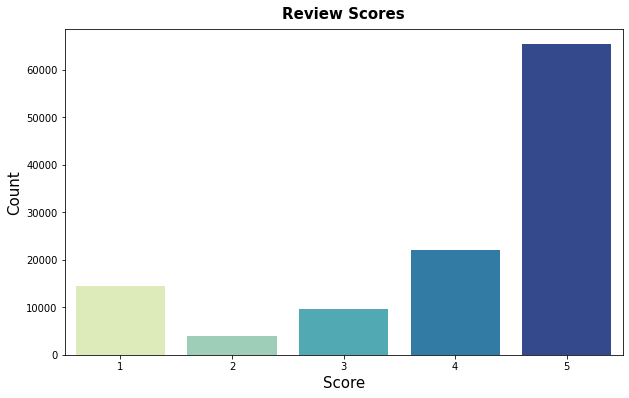

In [ ]:
#Bar graph of the general review score of the products

plt.figure(figsize=(10,6))
sns.countplot(x='review_score', data=full_data, palette='YlGnBu')
plt.title("Review Scores", fontsize=15, weight='bold',pad = 10.0)
plt.xlabel('Score', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.show()

In [29]:
#The first 30 columns of the data are taken to be able to write #SQL queries.
data = full_data.iloc[:,:27]
data.to_sql("data",conn, if_exists="replace")

In [10]:
#Average scores analyzed according to order status information

order_status = pd.read_sql(""" SELECT order_status, COUNT(*) AS count, AVG(review_score) AS AVG_Score  from data 
                    GROUP BY order_status
                    ORDER BY count DESC
                 """ , conn )
order_status

#It is seen that the number of submissions is quite high and has a good average score.

,order_status,count,AVG_Score
0,delivered,113210,4.082678
1,shipped,1138,1.987698
2,canceled,536,1.597015
3,invoiced,358,1.673184
4,processing,357,1.344538
5,unavailable,7,1.571429
6,approved,3,2.000000


## Top 10 Products

In [ ]:
#It is assumed that each row in the dataset is separate items of the order.
#For this reason, it is grouped according to product_id and the rows are counted.

top_ten_products = pd.read_sql(""" select product_id, Count(*) AS num , AVG(review_score) AS AVG_review,product_category_name_english  AS Category_nam from data
                                GROUP BY product_id
                                ORDER BY num DESC LIMIT 10
                                """,conn)
top_ten_products

#The ten best-selling products are in 6 different categories.

,product_id,num,AVG_review,Category_nam
0,aca2eb7d00ea1a7b8ebd4e68314663af,533,4.020638,furniture_decor
1,99a4788cb24856965c36a24e339b6058,517,3.914894,bed_bath_table
2,422879e10f46682990de24d770e7f83d,507,3.927022,garden_tools
3,389d119b48cf3043d311335e499d9c6b,405,4.106173,garden_tools
4,368c6c730842d78016ad823897a372db,395,3.908861,garden_tools
5,53759a2ecddad2bb87a079a1f1519f73,389,3.884319,garden_tools
6,d1c427060a0f73f6b889a5c7c61f2ac4,354,4.096045,computers_accessories
7,53b36df67ebb7c41585e8d54d6772e08,324,4.200617,watches_gifts
8,154e7e31ebfa092203795c972e5804a6,294,4.319728,health_beauty
9,3dd2a17168ec895c781a9191c1e95ad7,276,4.206522,computers_accessories


In [ ]:
top_ten_products['AVG_review'].mean()
#The scores of the products with high sales are also at a good level.

4.058481768900473

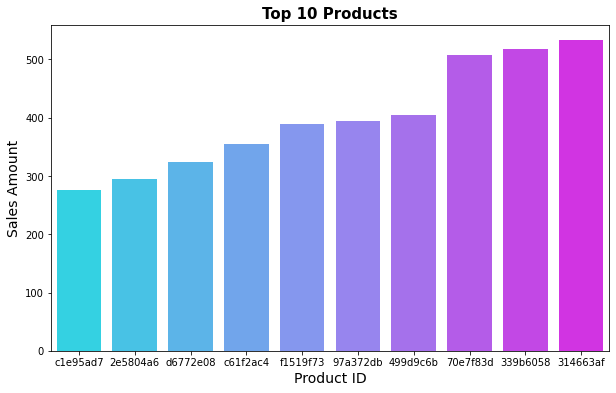

In [ ]:
#Plotting Top 10 Products
plt.figure(figsize=(10,6))
sns.countplot(x='product_id_shorten', data=full_data, palette='cool',
             order=full_data['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')
plt.xlabel("Product ID", fontsize = 14)
plt.ylabel("Sales Amount", fontsize = 14)
plt.show()

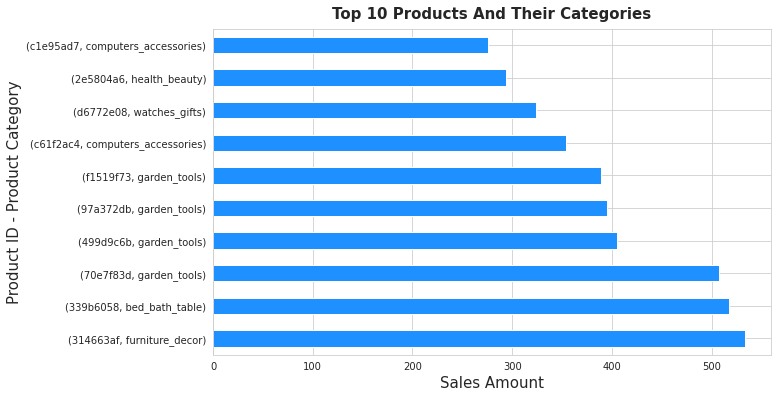

In [ ]:
#Top 10 Product And Their Categories

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
group_product= full_data.groupby(['product_id_shorten','product_category_name_english',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_product.plot(kind='barh',color='dodgerblue')
plt.title("Top 10 Products And Their Categories", fontsize=15, weight='bold',pad = 10.0)
plt.xlabel("Sales Amount", fontsize = 15)
plt.ylabel("Product ID - Product Category", fontsize = 15)
plt.show()

## Top 10 Categories

In [ ]:
top_ten_categories = pd.read_sql(""" SELECT product_category_name_english AS Category_Name, COUNT(*) AS num, SUM(price) AS Total_Price,
                                    AVG(review_score) AS AVG_Score , COUNT(DISTINCT(seller_id)) AS Num_of_Seller FROM data
                                    GROUP BY product_category_name_english
                                    ORDER BY num DESC limit 10
                                """ , conn )

top_ten_categories
#Although the most sold product is in the furniture_decor category, the most sold category is the bed_bath_table category.
#The two categories with the highest total price are health_beauty and watches_gifts.
#Bed_bath_table has more sales and almost one of the highest turnovers, although the number of sellers is lower.
#Products in this category can be kept in their own warehouses by the e-commerce company.

,Category_Name,num,Total_Price,AVG_Score,Num_of_Seller
0,bed_bath_table,11847,1095770.05,3.890605,195
1,health_beauty,9944,1290883.52,4.137973,491
2,sports_leisure,8942,1022489.29,4.107470,481
3,furniture_decor,8743,765336.72,3.912158,370
4,computers_accessories,8105,944992.54,3.936089,287
5,housewares,7331,664226.76,4.060428,467
6,watches_gifts,6161,1245783.11,4.017692,101
7,telephony,4692,335828.83,3.948849,147
8,garden_tools,4558,515987.77,4.023914,235
9,auto,4356,608914.30,4.064279,382


In [ ]:
#Average review score of the top ten categories
top_ten_categories['AVG_Score'].mean()

4.009945786866828

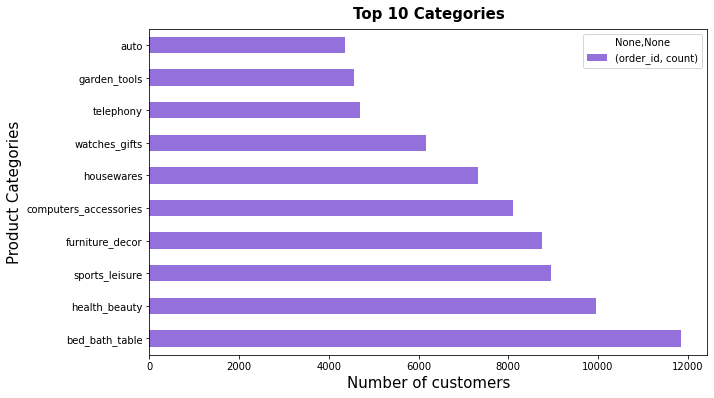

In [ ]:
#Plotting Top 10 Categories

group_category= full_data.groupby(by='product_category_name_english')[['order_id']].agg(['count']).sort_values(by=('order_id','count'),ascending=False).head(10)
group_category.plot(kind='barh',color='mediumpurple',figsize=(10,6))
plt.title("Top 10 Categories", fontsize=15, weight='bold',pad = 10.0)
plt.xlabel('Number of customers', fontsize = 15)
plt.ylabel('Product Categories', fontsize = 15)
plt.show()

In [11]:
#Let's look at category 2 with the highest turnover because the number of sellers is low. We can store products with low number of vendors ourselves.

watches_gifts =  pd.read_sql(""" SELECT customer_city AS Customer_City, COUNT(*) AS Num, SUM(price) AS Total_Price,
                                       AVG(review_score) AS AVG_Score , COUNT(DISTINCT(seller_id)) AS Num_of_Seller,
                                       MIN(DATE(order_purchase_timestamp)) AS First_order,
                                       MAX(DATE(order_purchase_timestamp)) AS Last_order ,
                                       julianday('2018-09-01 00:00:00.000')-julianday(MAX(DATE(order_purchase_timestamp))) AS num_of_days_from_last_order FROM data
                                       WHERE product_category_name_english = 'watches_gifts'
                                       GROUP BY customer_city
                                       ORDER BY num DESC  limit 10
                                            """ , conn )
watches_gifts
#Here the satisfaction rate of the city of Belo Horizonte is at a good level with 4.3.
#Let's examine this city and have an idea about its sellers.

,Customer_City,Num,Total_Price,AVG_Score,Num_of_Seller,First_order,Last_order,num_of_days_from_last_order
0,sao paulo,861,172050.07,4.130081,50,2016-10-03,2018-08-28,4.0
1,rio de janeiro,471,93088.87,3.804671,46,2016-10-08,2018-08-24,8.0
2,brasilia,152,33404.26,4.039474,33,2016-10-06,2018-08-17,15.0
3,belo horizonte,132,25799.81,4.325758,22,2017-03-16,2018-08-08,24.0
4,curitiba,110,16559.27,3.800000,26,2017-03-18,2018-08-25,7.0
5,salvador,90,19233.87,3.555556,19,2017-03-24,2018-08-16,16.0
6,guarulhos,87,16520.57,4.000000,22,2017-02-07,2018-08-22,10.0
7,campinas,83,18425.97,3.831325,21,2017-02-24,2018-08-24,8.0
8,fortaleza,81,14722.89,4.123457,15,2017-04-08,2018-08-16,16.0
9,porto alegre,71,13045.12,4.112676,17,2017-03-12,2018-08-21,11.0


In [13]:
#Watches-gifs sellers in Belo Horizonte

df = pd.read_sql("""          SELECT seller_id, COUNT(order_id)AS Num, SUM(price) AS Total_Price,
                              AVG(review_score) AS AVG_Score,
                              MIN(DATE(order_purchase_timestamp)) AS First_order,
                              MAX(DATE(order_purchase_timestamp)) AS Last_order ,
                              julianday('2018-09-01 00:00:00.000')-julianday(MAX(DATE(order_purchase_timestamp))) AS num_of_days_from_last_order FROM data
                              WHERE product_category_name_english = 'watches_gifts' AND customer_city = 'belo horizonte'
                              GROUP BY seller_id
                              ORDER BY num DESC LIMIT 10
                                            """ , conn )
df
#Although the sellers in the 3rd and 4th index have high scores, they have not made a sale for two months. Sales of these vendors can be encouraged.

,seller_id,Num,Total_Price,AVG_Score,First_order,Last_order,num_of_days_from_last_order
0,6560211a19b47992c3666cc44a7e94c0,32,2226.00,4.437500,2017-03-16,2018-08-01,31.0
1,4869f7a5dfa277a7dca6462dcf3b52b2,23,4291.10,3.956522,2017-06-11,2018-08-08,24.0
2,7d13fca15225358621be4086e1eb0964,18,3856.23,4.666667,2018-02-17,2018-08-06,26.0
3,fa1c13f2614d7b5c4749cbc52fecda94,15,6358.70,4.600000,2017-10-10,2018-07-03,60.0
4,634964b17796e64304cadf1ad3050fb7,6,641.00,4.833333,2018-01-22,2018-06-19,74.0
5,381c83fdca332ea6afd896da20bf6e4a,5,1475.00,5.000000,2017-11-24,2018-07-22,41.0
6,2eb70248d66e0e3ef83659f71b244378,4,499.60,1.500000,2018-05-29,2018-06-02,91.0
7,522620dcb18a6b31cd7bdf73665113a9,4,316.00,4.500000,2017-10-27,2018-03-05,180.0
8,7e93a43ef30c4f03f38b393420bc753a,4,2304.59,4.250000,2017-04-06,2017-10-16,320.0
9,86ccac0b835037332a596a33b6949ee1,4,300.59,4.000000,2017-04-14,2018-01-16,228.0


In [14]:
#The ten categories with the least sales

last_ten_categories =  pd.read_sql(""" SELECT product_category_name_english AS Category_Name, COUNT(*) AS Num, SUM(price) AS Total_Price,
                                       AVG(review_score) AS AVG_Score , COUNT(DISTINCT(seller_id)) AS Num_of_Seller,
                                       MIN(DATE(order_purchase_timestamp)) AS First_order,
                                       MAX(DATE(order_purchase_timestamp)) AS Last_order ,
                                       julianday('2018-09-01 00:00:00.000')-julianday(MAX(DATE(order_purchase_timestamp))) AS num_of_days_from_last_order FROM data
                                       GROUP BY product_category_name_english
                                       ORDER BY num  limit 10
                                            """ , conn )

last_ten_categories
#There has been no shopping in the Security category for a year and the score is low.
#Although the music category has 19 sellers and a high score, its sales are low.
#High-score categories can be examined and studies can be carried out on those who may have a demand.

,Category_Name,Num,Total_Price,AVG_Score,Num_of_Seller,First_order,Last_order,num_of_days_from_last_order
0,security_and_services,2,283.29,2.500000,2,2017-01-26,2017-09-17,349.0
1,fashion_childrens_clothes,8,569.85,4.500000,4,2017-05-17,2018-06-03,90.0
2,cds_dvds_musicals,14,730.00,4.642857,1,2017-07-05,2018-04-20,134.0
3,la_cuisine,15,2166.98,4.133333,2,2017-04-09,2018-04-17,137.0
4,arts_and_craftmanship,24,1814.01,4.125000,13,2017-05-08,2018-08-24,8.0
5,home_comfort_2,28,734.47,3.642857,4,2017-01-25,2018-07-28,35.0
6,fashion_sport,31,2144.50,4.258065,10,2017-03-04,2018-08-19,13.0
7,flowers,31,1000.24,4.419355,3,2017-11-06,2018-07-19,44.0
8,diapers_and_hygiene,39,1567.59,3.256410,8,2016-10-08,2018-08-26,6.0
9,music,40,6258.20,4.200000,19,2017-01-05,2018-08-19,13.0


In [15]:
#Top 10 categories with lowest scores
last_ten_score_categ= pd.read_sql(""" SELECT product_category_name_english AS Category_name ,COUNT(*) AS num, AVG(review_score) AS AVG_Score,
                                      SUM(price) AS Total_Price, COUNT(DISTINCT(seller_id)) AS Num_of_Seller ,
                                      MIN(DATE(order_purchase_timestamp)) AS First_order,
                                      MAX(DATE(order_purchase_timestamp)) AS Last_order ,
                                      julianday('2018-09-01 00:00:00.000')-julianday(MAX(DATE(order_purchase_timestamp))) AS num_of_days_from_last_order FROM data
                                      GROUP BY product_category_name_english
                                      ORDER BY AVG(review_score)  limit 10
                                          """ , conn )

last_ten_score_categ
#Although the sales are high in the office_furniture category, its score is 3.5.

,Category_name,num,AVG_Score,Total_Price,Num_of_Seller,First_order,Last_order,num_of_days_from_last_order
0,security_and_services,2,2.500000,283.29,2,2017-01-26,2017-09-17,349.0
1,diapers_and_hygiene,39,3.256410,1567.59,8,2016-10-08,2018-08-26,6.0
2,office_furniture,1773,3.526791,284368.09,34,2016-10-04,2018-08-28,4.0
3,fashion_male_clothing,144,3.548611,11436.61,13,2016-10-05,2018-08-17,15.0
4,home_comfort_2,28,3.642857,734.47,4,2017-01-25,2018-07-28,35.0
5,fixed_telephony,269,3.672862,61141.28,49,2016-10-04,2018-08-13,19.0
6,fashio_female_clothing,50,3.780000,2889.44,11,2016-10-05,2018-08-22,10.0
7,furniture_mattress_and_upholstery,41,3.804878,4835.88,5,2017-04-28,2018-07-03,60.0
8,audio,377,3.840849,52220.58,36,2016-10-07,2018-08-28,4.0
9,furniture_bedroom,126,3.841270,22175.68,23,2017-01-05,2018-08-25,7.0


In [16]:
#Let's take a closer look at the office furniture category.

furniture_office = pd.read_sql(""" Select seller_id, COUNT(*) AS Num, AVG(review_score) AS AVG_Score, 
                                  MIN(DATE(order_purchase_timestamp)) AS First_order,
                                  MAX(DATE(order_purchase_timestamp)) AS Last_order , 
                                  julianday('2018-09-01 00:00:00.000')-julianday(MAX(DATE(order_purchase_timestamp))) AS num_of_days_from_last_order from data
                                  WHERE product_category_name_english = 'office_furniture'
                                  GROUP BY seller_id
                                  ORDER BY Num DESC
                                """,conn)
furniture_office

#It is seen that the seller's scores in the 3rd and 6th indexes are low.
#On the other hand, it is striking that the seller in the 2nd index has not made sales for more than 1 year and has a score of 3.5, which is not bad.

,seller_id,Num,AVG_Score,First_order,Last_order,num_of_days_from_last_order
0,7c67e1448b00f6e969d365cea6b010ab,1315,3.443346,2017-01-27,2018-08-07,25.0
1,17a053fcb14bd219540cbde0df490be0,145,4.193103,2017-07-06,2018-08-13,19.0
2,a7f13822ceb966b076af67121f87b063,80,3.500000,2016-10-04,2017-05-04,485.0
3,5058e8c1e82653974541e83690655b4a,57,2.964912,2017-10-16,2018-07-31,32.0
4,b8555308bfdb4ca1ed54325a58da9a97,28,4.071429,2017-12-11,2018-08-23,9.0
5,f8db351d8c4c4c22c6835c19a46f01b0,19,4.789474,2017-04-29,2018-05-26,98.0
6,c26a2be5b53b7db6b276280da212a779,18,2.722222,2017-08-08,2018-08-03,29.0
7,67bf6941ba2f1fa1d02c375766bc3e53,17,3.941176,2017-09-17,2018-06-13,80.0
8,656591be56071d4c9ef4e5fee78a578a,11,4.636364,2017-03-06,2017-05-07,482.0
9,7fc87cc3e89b3d1d5cabdca32f8485aa,10,3.400000,2018-05-02,2018-07-30,33.0


In [17]:
#Top 10 selling categories and their percentage in total orders
group_category= full_data.groupby(by='product_category_name_english')[['order_id']].agg(['count']).sort_values(by=('order_id','count'),ascending=False)
group_category['Percent share of customers'] = group_category.apply(lambda x: (x/(x.sum()))*100)
group_category.head(10)

,order_id,Percent share of customers
,count,
product_category_name_english,,
bed_bath_table,11847,10.247472
health_beauty,9944,8.601406
sports_leisure,8942,7.734692
furniture_decor,8743,7.562560
computers_accessories,8105,7.010700
housewares,7331,6.341202
watches_gifts,6161,5.329170
telephony,4692,4.058508


In [ ]:
fig = px.pie(values=group_category['Percent share of customers'], names=group_category.index,title= 'Percentages of Product Categories')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=15, uniformtext_mode='hide')
fig.show()
#The top 10 categories account for almost 65% of all orders.

# Time Series Analysis

## Monthly Sales Analysis

Text(0, 0.5, 'Month')

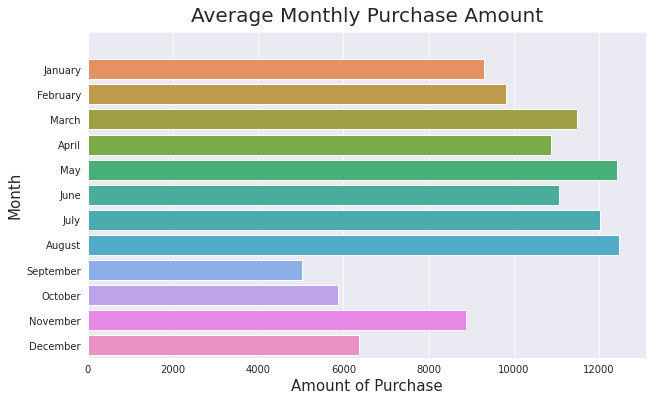

In [30]:
#Average sales by month

month = full_data.groupby('purchase_month').size().sort_values()
fig=plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.barplot(y=month.index, x=month.values)
plt.title('Average Monthly Purchase Amount',fontsize=20,pad = 10.0)
plt.xlabel('Amount of Purchase', fontsize = 15)
plt.ylabel('Month', fontsize = 15)

#This image may mislead us, as we have the data for the whole of 2017 and about half of 2018.

## Year-Monthly Sales Analysis

Text(0, 0.5, 'Year-Month')

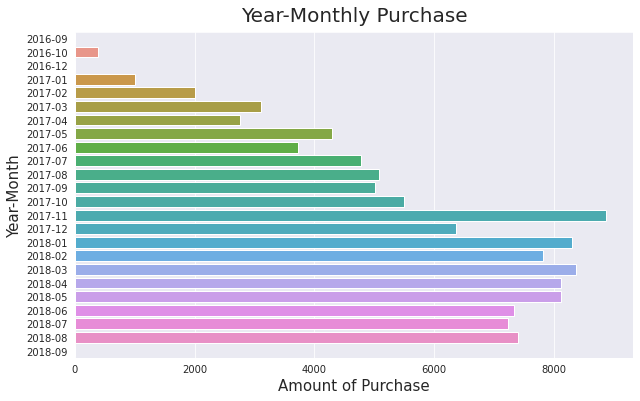

In [31]:
#Let's take a look at all the months we have as Month-Year:

Month_Year = full_data.groupby('purchase_MonthY').size().sort_index()
fig=plt.figure(figsize=(10,6))
sns.barplot(y=Month_Year.index, x=Month_Year.values)
plt.title('Year-Monthly Purchase',fontsize=20,pad = 10.0)
plt.xlabel('Amount of Purchase', fontsize = 15)
plt.ylabel('Year-Month', fontsize = 15)

#It is seen that there is a big sale in November due to Black Friday.

## Daily Sales Analysis

Text(0, 0.5, 'Day')

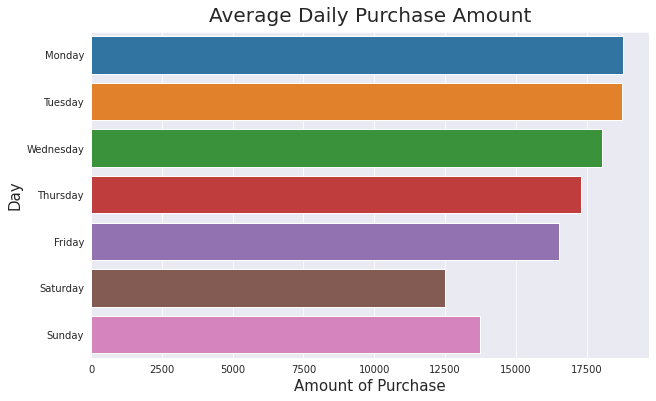

In [32]:
#Sales by day

day = full_data.groupby('purchase_day').size().sort_values()
fig=plt.figure(figsize=(10,6))
sns.barplot(y=day.index, x=day.values)
plt.title('Average Daily Purchase Amount',fontsize=20,pad = 10.0)
plt.xlabel('Amount of Purchase', fontsize = 15)
plt.ylabel('Day', fontsize = 15)

#It can be said that more shopping is done on weekdays.

## Hourly Sales Analysis

Text(0, 0.5, 'Purchase Amount')

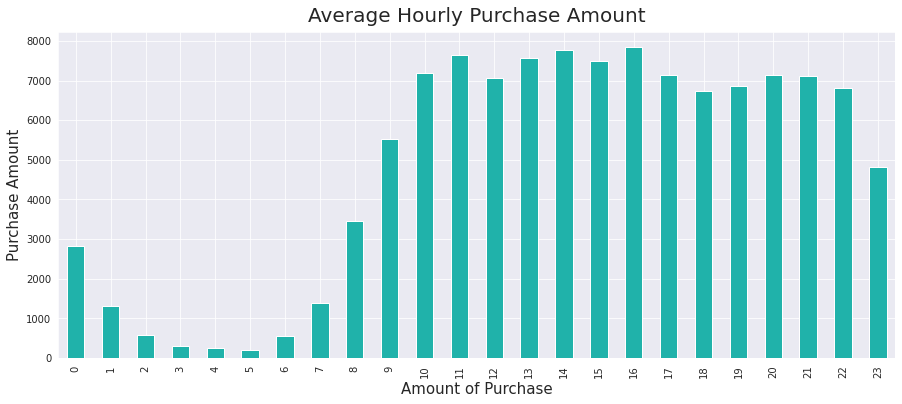

In [50]:
#Sales by the hour

full_data.groupby('purchase_time').size().sort_index().plot(kind='bar',figsize=(15,6),color='lightseagreen')
plt.title('Average Hourly Purchase Amount',fontsize=20,pad = 10.0)
plt.xlabel('Amount of Purchase', fontsize = 15)
plt.ylabel('Purchase Amount', fontsize = 15)

#It is seen that sales are made between 10 a.m. and 10 p.m.


# Customer Analysis

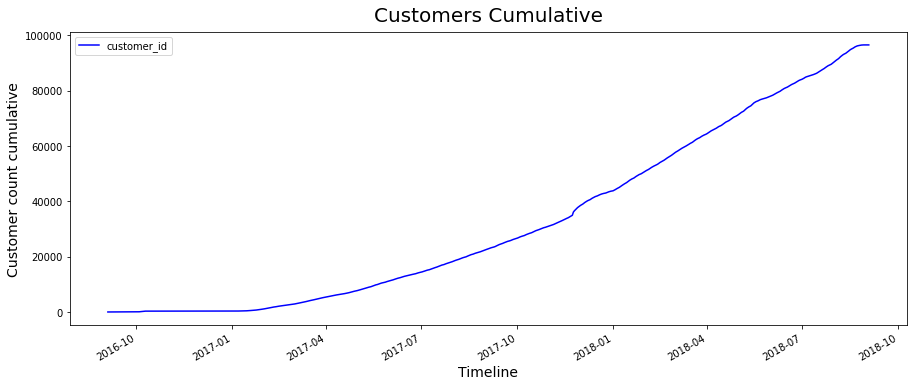

In [ ]:
#If we look at the cumulative number of customers:

customer_cumulative = full_data.groupby('customer_id',as_index=False).agg({'order_purchase_timestamp': 'min'})
customer_cumulative.groupby('order_purchase_timestamp').count().cumsum().plot(figsize=(15,6),color='blue')
plt.title('Customers Cumulative',fontsize=20,pad = 10.0)
plt.xlabel('Timeline', fontsize = 14)
plt.ylabel('Customer count cumulative', fontsize = 14);

#As expected, an increasing graph emerges.

In [51]:
#Let's take a look at the last time customers shopped.

customer_orders = pd.read_sql(""" SELECT customer_unique_id AS Customer_ID, COUNT(order_id) AS num_of_order, SUM(price) AS price,
                                  AVG(review_score) AS AVG_Score, DATE(MAX(order_purchase_timestamp)) AS last_order ,
                                  julianday('2018-09-01 12:08:15.310')-julianday(DATE(MAX(order_purchase_timestamp))) AS not_order_for 
                                  from data 
                                  GROUP BY customer_unique_id
                                  ORDER BY last_order
                              """ , conn )
#Customers who have not shopped in the last 100 days
inactive_customer = customer_orders[customer_orders['not_order_for'] > 100]

#Customers who shopped in the last 100 days
active_customer = customer_orders[customer_orders['not_order_for'] < 100]
inactive_customer

,Customer_ID,num_of_order,price,AVG_Score,last_order,not_order_for
0,b7d76e111c89f7ebf14761390f0f7d17,2,72.89,1.0,2016-09-04,727.505733
1,4854e9b3feff728c13ee5fc7d1547e92,1,59.50,1.0,2016-09-05,726.505733
2,0eb1ee9dba87f5b36b4613a65074337c,1,100.00,1.0,2016-10-02,699.505733
3,10e89fd8e5c745f81bec101207ba4d7d,1,74.90,1.0,2016-10-03,698.505733
4,2f64e403852e6893ae37485d5fcacdaf,1,21.90,4.0,2016-10-03,698.505733
...,...,...,...,...,...,...
74071,f58b624587c166dc243abc92d8128b9e,1,929.00,5.0,2018-05-24,100.505733
74072,f69ed448d3c70ab7a332ca8a95fc2261,1,299.99,5.0,2018-05-24,100.505733
74073,faa4c0aa4d5c9f68462157777cee81fe,1,69.90,4.0,2018-05-24,100.505733
74074,fd8d67c9f12ff483d867a15f3cd401f7,1,84.90,5.0,2018-05-24,100.505733


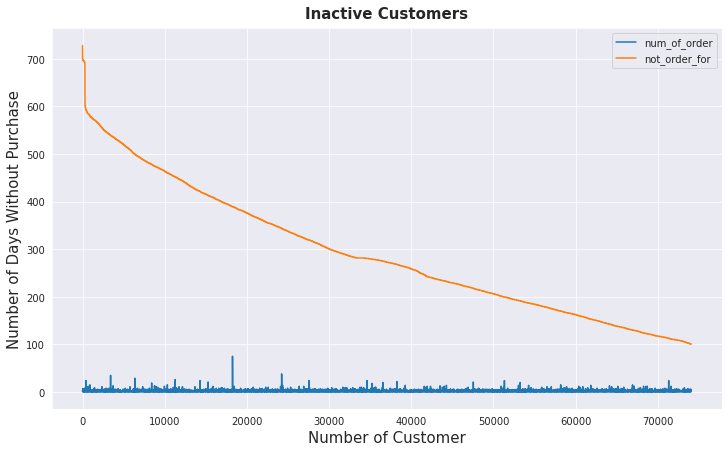

In [52]:
#Inactive Customer Graph
inactive_graph = pd.concat([inactive_customer['num_of_order'] , inactive_customer['not_order_for']],axis=1)
inactive_graph.plot(figsize=(12,7))
plt.title("Inactive Customers", fontsize=15, weight='bold',pad = 10.0)
plt.xlabel('Number of Customer', fontsize = 15)
plt.ylabel('Number of Days Without Purchase', fontsize = 15)
plt.show()
#The orange line represents how many days each customer has not shopped. The blue line shows the total number of purchases for each customer.

In [55]:
total_customers = inactive_customer['Customer_ID'].count() + active_customer['Customer_ID'].count()
total_customers

93396

In [56]:
inactive_customer['Customer_ID'].count() / total_customers
#79 percent of our customers are inactive

0.7931388924579211

In [57]:
active_customer['Customer_ID'].count() / total_customers
#About 20 percent of our customers are active

0.2068611075420789

In [61]:
total_price = inactive_customer['price'].sum() + active_customer['price'].sum()
total_price

13944740.190000001

In [62]:
inactive_customer['price'].sum() / total_price
#Inactive customers account for 79 percent of our earnings.

0.7919400067359734

In [63]:
active_customer['price'].sum() / total_price

0.20805999326402652

In [68]:
active_customer[active_customer['AVG_Score']>4]['AVG_Score'].count() / active_customer['AVG_Score'].count()
#approximately 63 percent of our active customers are satisfied with their purchases

0.6373706004140787

In [65]:
inactive_customer[inactive_customer['AVG_Score']>4]['AVG_Score'].count() / inactive_customer['AVG_Score'].count()
#our inactive customers are slightly less satisfied

0.5659187861115611

In [66]:
inactive_customer[inactive_customer['AVG_Score']<3]['AVG_Score'].count() / inactive_customer['AVG_Score'].count()
#15 percent of inactive customers have a review score of less than 3

0.15056158539877962

In [67]:
active_customer[active_customer['AVG_Score']<3]['AVG_Score'].count() / active_customer['AVG_Score'].count()

0.10564182194616978


## City ​​Based Customer Analysis

In [69]:
#Total number of customers

Number_of_customers = full_data.customer_unique_id.nunique()
Number_of_customers

93396

In [70]:
#Cities and percentages of customers

customer_city = full_data.groupby(by='customer_city')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)[0:15]
customer_city['Percent share of customers'] = customer_city.apply(lambda x: (x/(Number_of_customers))*100)
customer_city

,customer_unique_id,Percent share of customers
,count,
customer_city,,
sao paulo,18267,19.558653
rio de janeiro,8022,8.589233
belo horizonte,3196,3.421988
brasilia,2434,2.606107
curitiba,1790,1.916570
campinas,1702,1.822348
porto alegre,1632,1.747398
salvador,1468,1.571802


In [71]:
#Total earnings and average earnings by cities
full_data.groupby(by='customer_city')[['payment_value']].agg(['sum','mean']).sort_values(by=('payment_value','sum'),ascending=False)[0:15]

payment_value            
                                sum        mean
customer_city                                  
sao paulo                2807526.03  153.693876
rio de janeiro           1536347.93  191.516820
belo horizonte            492767.96  154.182716
brasilia                  428036.30  175.857149
curitiba                  327886.88  183.177028
porto alegre              311302.47  190.749063
salvador                  281542.27  191.786287
campinas                  262096.32  153.993137
guarulhos                 199503.82  145.623226
niteroi                   174032.30  167.338750
goiania                   162354.93  198.720845
fortaleza                 148260.18  198.474137
santos                    147826.08  178.749794
sao bernardo do campo     147765.16  134.576648
recife                    127234.45  184.933794

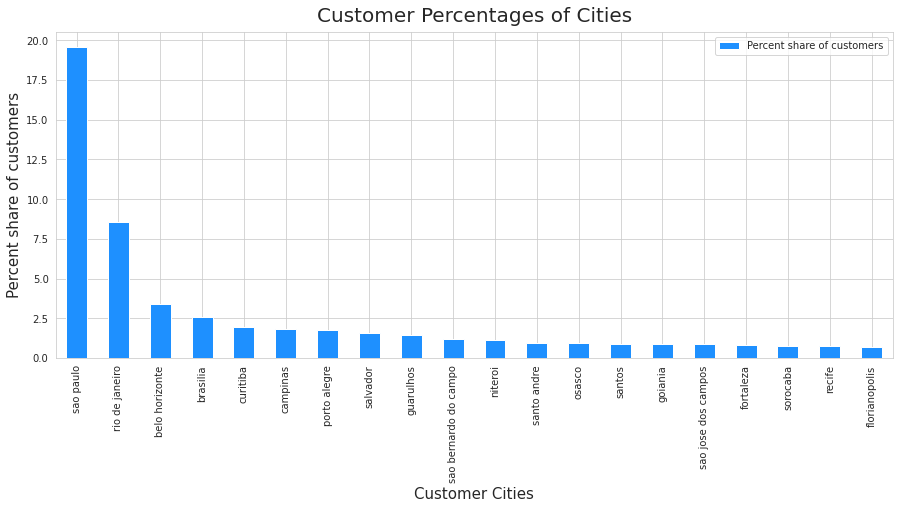

In [ ]:
#Graph of percentages of cities where customers are located

sns.set_style("whitegrid")
plt.figure(figsize=(15,6))
df = full_data.groupby(by='customer_city')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)[:20]
df['Percent share of customers'] = df.apply(lambda x: (x/(Number_of_customers))*100)
df['Percent share of customers'].plot(kind='bar',color='dodgerblue')
plt.title('Customer Percentages of Cities',fontsize=20,pad = 10.0)
plt.xlabel('Customer Cities', fontsize = 15)
plt.ylabel('Percent share of customers', fontsize = 15)
plt.legend()
plt.show()

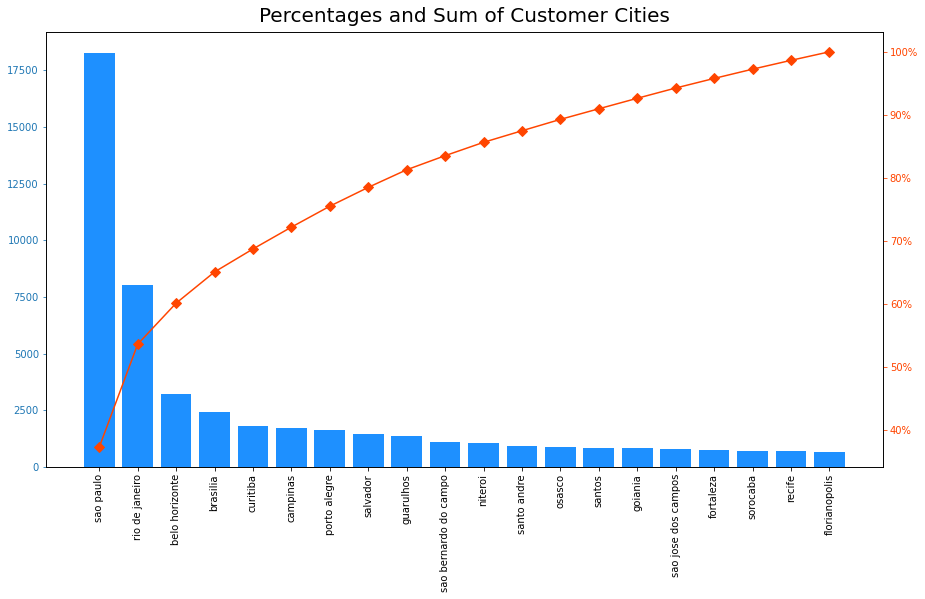

In [ ]:
# Adding cummulative percentage for Pareto Chart
df = full_data.groupby(by='customer_city')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)[:20]
df['Percent share of customers'] = df.apply(lambda x: (x/(Number_of_customers))*100)
df["cumpercentage"] = df["Percent share of customers"].cumsum()/df["Percent share of customers"].sum()*100

#Plotting Pareto chart
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(df.index, df[('customer_unique_id','count')], color="dodgerblue",width=0.8)
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="orangered", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="x",rotation=90)
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="orangered")
plt.title('Percentages and Sum of Customer Cities',fontsize=20,pad = 10.0)
plt.show()

## State ​​Based Customer Analysis

In [ ]:
#Countries and percentages of customers
customer_state = full_data.groupby(by='customer_state')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)[0:15]
customer_state['Percent share of customers'] = customer_state.apply(lambda x: (x/(Number_of_customers))*100)
customer_state

,customer_unique_id,Percent share of customers
,count,
customer_state,,
SP,48797,52.247420
RJ,14987,16.046726
MG,13429,14.378560
RS,6413,6.866461
PR,5879,6.294702
SC,4218,4.516253
BA,3942,4.220738
DF,2449,2.622168


In [ ]:
#Total and average earnings from countries
full_data.groupby(by='customer_state')[['payment_value']].agg(['sum','mean']).sort_values(by=('payment_value','sum'),ascending=False)[0:15]

payment_value            
                         sum        mean
customer_state                          
SP                7502926.95  153.757955
RJ                2708839.33  180.745935
MG                2288949.71  170.448262
RS                1131899.22  176.500736
PR                1055747.81  179.579488
BA                 780334.54  197.953968
SC                 769744.94  182.490503
GO                 459466.06  194.771539
DF                 430126.51  175.633528
ES                 390840.58  169.930687
PE                 368309.23  198.978514
CE                 337096.92  220.757642
MT                 253916.03  229.580497
PA                 241870.17  223.746688
MA                 195954.74  235.522524

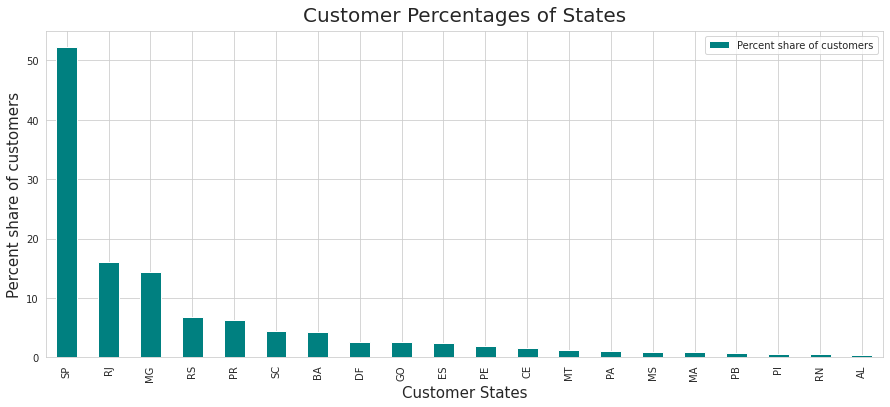

In [ ]:
#Graph of percentage of customers in countries
plt.figure(figsize=(15,6))
df = full_data.groupby(by='customer_state')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)[:20]
df['Percent share of customers'] = df.apply(lambda x: (x/(Number_of_customers))*100)
df['Percent share of customers'].plot(kind='bar',color='teal')
plt.title('Customer Percentages of States',fontsize=20,pad = 10.0)
plt.xlabel('Customer States', fontsize = 15)
plt.ylabel('Percent share of customers', fontsize = 15)
plt.legend()
plt.show()

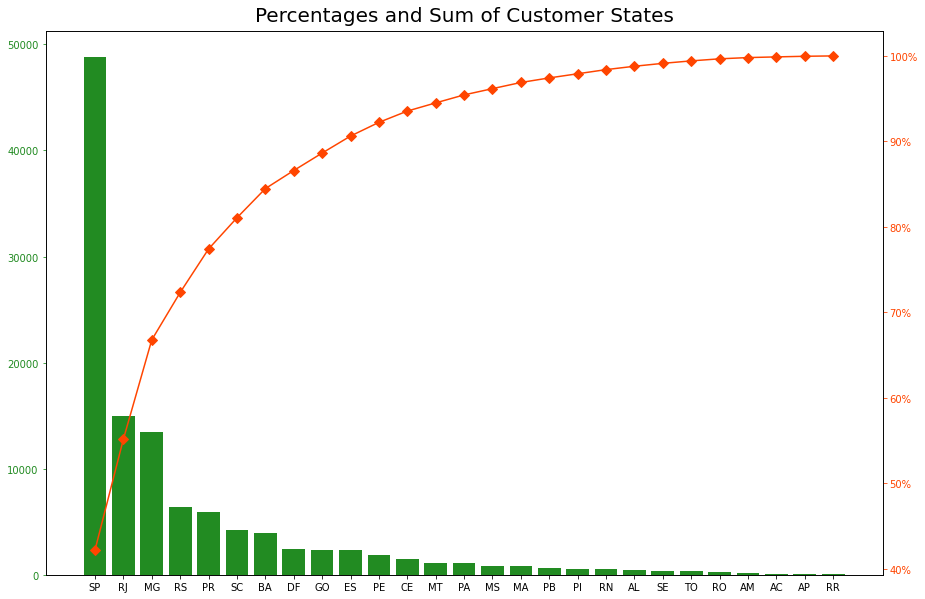

In [ ]:
# Adding cummulative percentage for Pareto Chart
df = full_data.groupby(by='customer_state')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)
df['Percent share of customers'] = df.apply(lambda x: (x/(Number_of_customers))*100)
df["cumpercentage"] = df["Percent share of customers"].cumsum()/df["Percent share of customers"].sum()*100

#Plotting Pareto chart
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df.index, df[('customer_unique_id','count')], color="forestgreen",width=0.8)
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="orangered", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="forestgreen")
ax2.tick_params(axis="y", colors="orangered")
plt.title('Percentages and Sum of Customer States',fontsize=20,pad = 10.0)
plt.show()

## Payment Types

In [ ]:
#Let's create dataframe for payment types at look at some numbers

df = full_data.groupby(by='payment_type')[['customer_unique_id']].agg(['count']).sort_values(by=('customer_unique_id','count'),ascending=False)
df['Percent customers'] = df.apply(lambda x: (x/(Number_of_customers))*100)
df['Payments'] = np.round(full_data.groupby(by='payment_type')[['payment_value']].agg(['sum']),4)
total_payment_value = df['Payments'].sum()

#Calculating percent shares
def percent_payment(x):
  z = x/total_payment_value
  return z * 100

df['Percent payment value'] = df['Payments'].apply(lambda x: percent_payment(x))
df

,customer_unique_id,Percent customers,Payments,Percent payment value
,count,,,
payment_type,,,,
credit_card,85278,91.307979,15300700.21,76.774005
boleto,22510,24.101675,3983145.42,19.986146
voucher,6162,6.597713,396168.16,1.987845
debit_card,1659,1.776307,249518.71,1.252005


In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=df.index, values=df['Percent customers'], name="Percent customers"),
              1, 1)
fig.add_trace(go.Pie(labels=df.index, values=df['Percent payment value'], name="'Percent payment value'"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Payment Types",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Customer', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Price', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [ ]:
#Most used installment amounts
payment_seq = pd.read_sql ( """ select payment_sequential, COUNT(*) as num ,AVG(review_score) AS score from data
              GROUP BY payment_sequential
              ORDER BY num DESC LIMIT 10
""",conn)
payment_seq
#In general, there is a cash purchase, which may be due to the low price per order.
#Installments can be made by increasing the debt

,payment_sequential,num,score
0,1,110662,4.035721
1,2,3298,4.016070
2,3,636,3.905660
3,4,307,4.100977
4,5,183,4.027322
5,6,127,3.968504
6,7,88,3.954545
7,8,58,4.034483
8,9,47,3.978723
9,10,40,3.975000



# Seller Analysis

## Total Number of Sellers

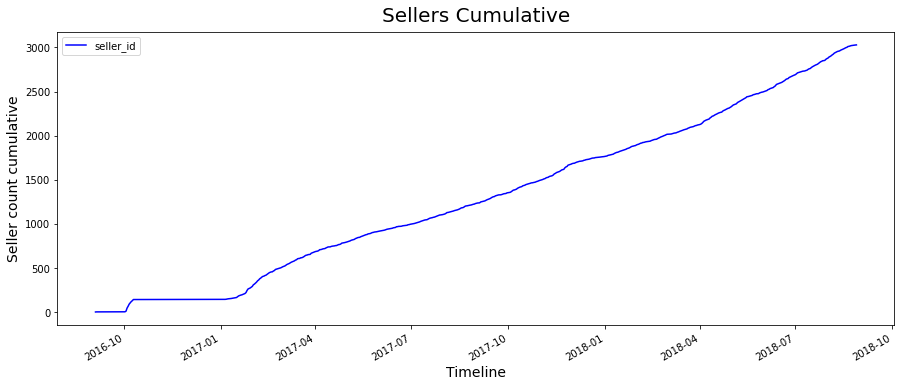

In [ ]:
#Graph of number of sellers over time

seller_cumulative = full_data.groupby('seller_id',as_index=False).agg({'order_purchase_timestamp': 'min'})
seller_cumulative.groupby('order_purchase_timestamp').count().cumsum().plot(figsize=(15,6),color='blue')
plt.title('Sellers Cumulative',fontsize=20,pad = 10.0)
plt.xlabel('Timeline', fontsize = 14)
plt.ylabel('Seller count cumulative', fontsize = 14);

In [ ]:
#Total number of sellers
Number_of_sellers = full_data.seller_id.nunique()
Number_of_sellers

3028

## Actice and Inactive Sellers

In [ ]:
#Let's look at the last time sellers made a sale.

seller_orders = pd.read_sql(""" SELECT seller_id AS Seller_ID, COUNT(order_id) AS num_of_order, SUM(price) AS price,
                                  AVG(review_score) AS AVG_Score, DATE(MAX(order_purchase_timestamp)) AS last_order ,
                                  julianday('2018-07-01 12:08:15.310')-julianday(DATE(MAX(order_purchase_timestamp))) AS not_order_for 
                                  from data 
                                  GROUP BY seller_id
                                  ORDER BY last_order
                              """ , conn )
#Sellers who have not made a sale in the last 100 days
inactive_seller = seller_orders[seller_orders['not_order_for'] > 100]

#Sellers who have made a sale in the last 100 days
active_seller = seller_orders[seller_orders['not_order_for'] < 100]
inactive_seller

,Seller_ID,num_of_order,price,AVG_Score,last_order,not_order_for
0,f09b760d23495ac9a7e00d29b769007c,1,21.90,4.000000,2016-10-03,636.505733
1,bac44fa8e13424950488659b5f765c41,1,19.90,5.000000,2016-10-04,635.505733
2,0336182e1b3e92f029d5354832045fdf,2,29.80,2.000000,2016-10-05,634.505733
3,4b90495391ac0bd181a80a459df1e718,1,248.00,4.000000,2016-10-05,634.505733
4,4be2e7f96b4fd749d52dff41f80e39dd,1,267.00,1.000000,2016-10-05,634.505733
...,...,...,...,...,...,...
900,be67f78487e2cecb0d55bc769709e4f5,1,102.00,5.000000,2018-03-23,100.505733
901,c8467937e403e76a8ee9f0ab13f6f5ef,31,1780.99,4.032258,2018-03-23,100.505733
902,d1e2fe627180431ffda076abb303c56f,2,578.00,1.000000,2018-03-23,100.505733
903,e99e927c81e3f51739c94fcdfca9f10f,27,2902.79,3.592593,2018-03-23,100.505733


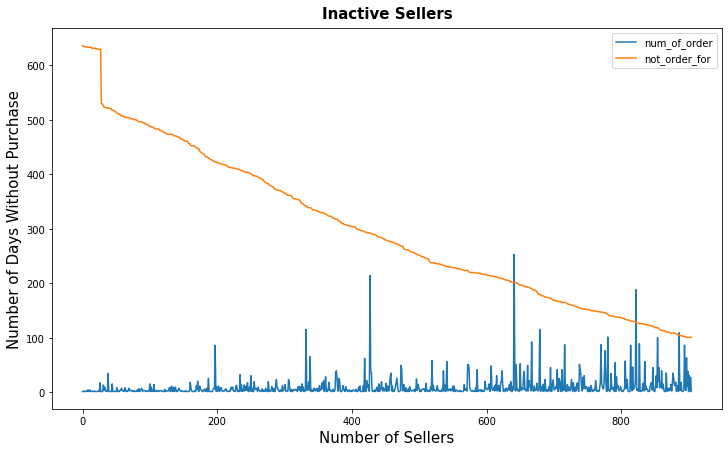

In [ ]:
#Graph of inactive sellers and total sales

inactive_graph = pd.concat([inactive_seller['num_of_order'] , inactive_seller['not_order_for']],axis=1)
inactive_graph.plot(figsize=(12,7))
plt.title("Inactive Sellers", fontsize=15, weight='bold',pad = 10.0)
plt.xlabel('Number of Sellers', fontsize = 15)
plt.ylabel('Number of Days Without Purchase', fontsize = 15)
plt.show()

In [ ]:
#Inactive sellers, what percentage of total sellers
inactive_seller['Seller_ID'].count() / Number_of_sellers

0.2988771466314399

In [ ]:
#Active sellers, what percentage of total sellers
active_seller['Seller_ID'].count() / Number_of_sellers

0.7011228533685601

In [ ]:
#Total Price
total_price = inactive_seller['price'].sum() + active_seller['price'].sum()
total_price

13944740.189999988

In [ ]:
#Percentage of inactive sellers in total price
inactive_seller['price'].sum() / total_price

0.08905101945825503

In [ ]:
#Percentage of active sellers in total price
active_seller['price'].sum() / total_price

0.910948980541745

In [ ]:
#total order
total_order = inactive_seller['num_of_order'].sum() + active_seller['num_of_order'].sum()
total_order

115609

In [ ]:
#Percentage of inactive sellers in total sales
inactive_seller['num_of_order'].sum() / total_order

0.0711622797533064

In [ ]:
#Percentage of active sellers in total sales
active_seller['num_of_order'].sum() / total_order

0.9288377202466936

In [ ]:
#Percentage of inactive sellers with a score greater than 4
inactive_seller[inactive_seller['AVG_Score']>4]['AVG_Score'].count() / inactive_seller['AVG_Score'].count()

0.46298342541436466

In [ ]:
#Percentage of active sellers with a score greater than 4
active_seller[active_seller['AVG_Score']>4]['AVG_Score'].count() / active_seller['AVG_Score'].count()

0.6325953838907207

In [ ]:
seller_inf = pd.read_sql ( """ select seller_id, COUNT(*) as num ,AVG(review_score) AS score from data
              GROUP BY seller_id
              ORDER BY score DESC
""",conn)
good_sellers = seller_inf[seller_inf['num']>500]
print("Number of sellers selling more than 500 units                 :",good_sellers['seller_id'].count())
print("Average number of sales of sellers selling more than 500 units:",good_sellers['num'].mean())
print("Average score of sales of sellers selling more than 500 units :",good_sellers['score'].mean())

Number of sellers selling more than 500 units                 : 29
Average number of sales of sellers selling more than 500 units: 1052.9310344827586
Average score of sales of sellers selling more than 500 units : 4.007924071497511


## States of Sellers

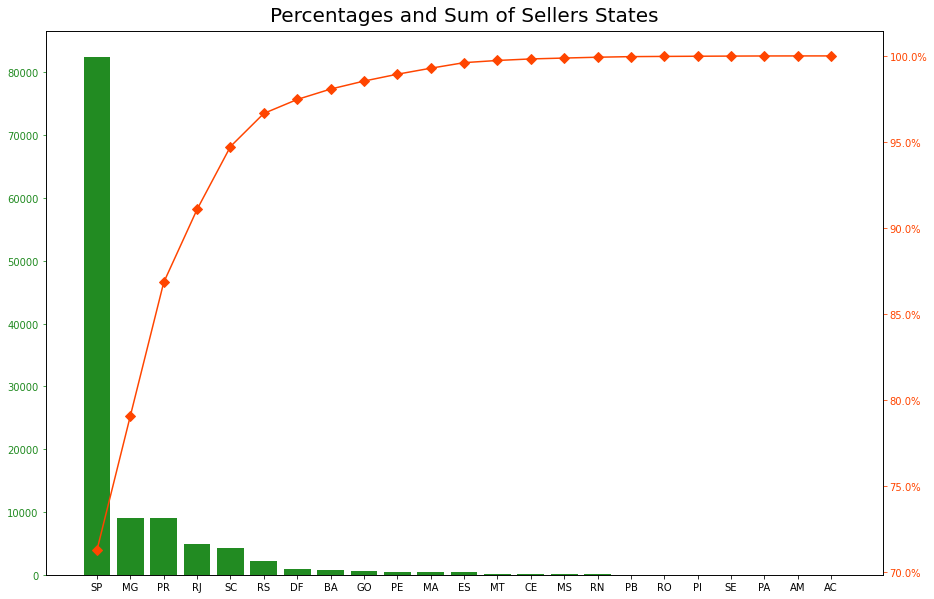

In [ ]:
#Countries where sellers are located
num_sellers = full_data.seller_id.nunique()
# Adding cummulative percentage for Pareto Chart
df = full_data.groupby(by='seller_state')[['seller_id']].agg(['count']).sort_values(by=('seller_id','count'),ascending=False)
df['Percent share of seller'] = df.apply(lambda x: (x/(num_sellers))*100)
df["cumpercentage"] = df["Percent share of seller"].cumsum()/df["Percent share of seller"].sum()*100

#Plotting Pareto chart
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(df.index, df[('seller_id','count')], color="forestgreen",width=0.8)
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="orangered", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="forestgreen")
ax2.tick_params(axis="y", colors="orangered")
plt.title('Percentages and Sum of Sellers States',fontsize=20,pad = 10.0)
plt.show()

# Delivery Analysis

In [ ]:
print("Shipping Time",full_data['shipping_duration'].mean())
print("Estimated Time",full_data['estimated_duration'].mean())
#It can be said that the delivery times are generally successful.

Shipping Time 12 days 15:51:47.000320044
Estimated Time 24 days 12:03:16.925844873


In [ ]:
#Top 10 countries with shortest delivery time
full_data.groupby('customer_state')[['shipping_duration']].mean().sort_values(by='shipping_duration').head(10)

,shipping_duration
customer_state,
SP,8 days 22:00:20.214357440
PR,12 days 02:26:57.826160911
MG,12 days 03:21:48.481644202
DF,13 days 05:48:05.585953450
SC,14 days 23:57:57.098150782
RS,15 days 09:09:54.479962576
RJ,15 days 10:39:37.580569827
GO,15 days 11:34:03.408223823
MS,15 days 12:58:47.573964497


In [ ]:
#How many of my orders were delivered late?
late_delivery = full_data[full_data['order_estimated_delivery_date'] < full_data['order_delivered_customer_date']] ['order_id'].count()  
late_delivery

7247

In [ ]:
totalOrders = full_data.order_id.nunique()
late_delivery / totalOrders
#Considering the percentage, a very small amount was delivered late. Overall good delivery.

0.07508599610427287